# EDA: CheXpert

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# import libraries
import pandas as pd
pd.options.display.max_columns = None
import numpy as np
import random
import os

# Matplotlib
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

In [3]:
from fastai.vision import *

In [4]:
os.getcwd()

'/Users/jai/Documents/Springboard-DS-Portfolio/capstone_2/exploration'

In [5]:
# need this to change to necessary directory
os.chdir('/Users/jai/Documents/Springboard-DS-Portfolio/capstone_2')

In [6]:
# import capstone to perform exploratory data analysis
from capstone import eda
path = eda.eda_path(os.getcwd())
path

PosixPath('/Users/jai/Documents/Springboard-DS-Portfolio/capstone_2')

In [7]:
# create train and valid dfs
train_df, valid_df = eda.load_data(path);

In [8]:
# print info on dataframes
eda.print_info([train_df, valid_df])

0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223414 entries, 0 to 223413
Data columns (total 19 columns):
Path                          223414 non-null object
Sex                           223414 non-null object
Age                           223414 non-null int64
Frontal/Lateral               223414 non-null object
AP/PA                         191027 non-null object
No Finding                    22381 non-null float64
Enlarged Cardiomediastinum    44839 non-null float64
Cardiomegaly                  46203 non-null float64
Lung Opacity                  117778 non-null float64
Lung Lesion                   11944 non-null float64
Edema                         85956 non-null float64
Consolidation                 70622 non-null float64
Pneumonia                     27608 non-null float64
Atelectasis                   68443 non-null float64
Pneumothorax                  78934 non-null float64
Pleural Effusion              133211 non-null float64
Pleural Other                 6492 non

# _Observations: Info on Training and Validation Data_

Above you can see high-level information from the provided training and validation CSV files. The training set, which we'll use to train our deep learning model, has nearly 223,414 entries with 19 columns. Most of these columns are devoted to the specific pathologies like `Enlarged Cardiomediastinum` and `Atelectasis` to `Support Devices` (i.e., this is 'technically' not a pathology but was included by the team at Stanford based on its prevalence within the images). 

The `Path` column represents the 'path' to the image, which will come in handy once we get to the model training portion of the capstone. The information in this column assists the learner to connect an observation from the CSV file to the associated image file within our data folder. 

There are two somewhat obvious columns - `Sex` and `Age` - that represents whether the patient was male or female and the patient's age, respectively. 

The next two columns indicate the positioning of the medical image. In this specific data set, x-rays were done from either the front (i.e., frontal) or the side (i.e., lateral), which is indicated by the `Frontal/Lateral` column. Lastly, the `AP/PA` shows whether or not the patient was standing or lying down when the imaging was done (which we'll dive further into a little later). 

Another critical thing to make a note of is that `train_df` has quite a few `NaN`, meaning that there is missing information. However, upon further investigation of Stanford's Machine Learning GitHub [page](https://github.com/stanfordmlgroup/chexpert-labeler/issues/9), we can clarify that missing values mean that no mention of that particular pathology was extracted via the labeler. Stanford treated those cases as negative (i.e. `0`) when they created their model so we can begin by inputting `0` for these pathological columns.

In [9]:
train_df = eda.fill_pathologies_nan(train_df);

Path                          0.000000
Sex                           0.000000
Age                           0.000000
Frontal/Lateral               0.000000
AP/PA                         0.144964
No Finding                    0.000000
Enlarged Cardiomediastinum    0.000000
Cardiomegaly                  0.000000
Lung Opacity                  0.000000
Lung Lesion                   0.000000
Edema                         0.000000
Consolidation                 0.000000
Pneumonia                     0.000000
Atelectasis                   0.000000
Pneumothorax                  0.000000
Pleural Effusion              0.000000
Pleural Other                 0.000000
Fracture                      0.000000
Support Devices               0.000000
dtype: float64


## _Observations_

The function above used the `eda.py` python script from our custom `capstone` module, which contains an assortment of defined functions that make the EDA more efficient with the additional upside of making the Notebook look a little bit cleaner as well! It seems like all of the `NaN` within the pathologies columns are good to go and no longer have any missing values!

How did the `fill_pathologies_nan()` function work though?

It takes as input a data frame and then starts by gathering a list of all the pathologies, which then can be used to select just those columns within `train_df`. Once we've chosen these columns, we can use the `fillna(0)` function followed by the `astype(int)` functions, which fill any `NaN` observations with the value of 0 and then casts all the values as integer types. To check how many `NaN`s are left, it prints out the percentage of observations for each column that represent missing values. 

It looks like we're not done though with null values; let's take a look at the `AP/PA` column as it appears that ~14% of the observations are missing values in this particular column. 

In [10]:
train_df['AP/PA'].head(10)

0     AP
1     AP
2     AP
3    NaN
4     AP
5     PA
6    NaN
7     PA
8    NaN
9     AP
Name: AP/PA, dtype: object

In [11]:
train_df['AP/PA'].value_counts(dropna=False)

AP     161590
NaN     32387
PA      29420
LL         16
RL          1
Name: AP/PA, dtype: int64

In [12]:
train_df['AP/PA'].value_counts(normalize=True, dropna=False)

AP     0.723276
NaN    0.144964
PA     0.131684
LL     0.000072
RL     0.000004
Name: AP/PA, dtype: float64

# _What do `AP`, `PA` mean?_

While 14% may not sound like a lot when you consider there are approximately 223k observations that 14% adds up to a little over 32,000 missing values. For most data sets, there are specific techniques you can use to address missing values - replace with the mean or median, use linear regression to predict the value, etc. - but with this data set, we're somewhat stuck because we're dealing with images and can't merely input a number. 

As a reminder `AP/PA` has to do with the positioning of the medical image so if we wanted to maintain the integrity of our data (at least within the CSV file), we'd have to go through each image and manually label them one by one, preferably with the assistance of a domain expert (i.e., board-certified radiologist(s)). Now, what exactly do PA and AP mean?

`PA` stands for posterior-anterior, which is obtained when the patient is in a standing position, facing the cassette and the x-ray tube is approximately 72 inches away.

`AP` stands for anterior-posterior, which is when the patient is lying down, and the x-ray tube is only 40 inches from the patient. [(Source)](https://www.med-ed.virginia.edu/courses/rad/cxr/technique3chest.html)

In summary, it indicates whether or not a patient was sitting or standing when the image(s) were taken. In a traditional setting (i.e., a hospital or healthcare facility), radiologists have access to top of the line medical imaging equipment, which allows them to analyze images at a very high pixel rate. Unfortunately, we do not have access to these high-resolution images because that would require a significant amount of storage. The small downsampled version is 11 gigabytes, compared to 439 gigabytes for the 'original' version of the images, which are not downscaled but reduced to 8-bit png images. What does this mean? These 8-bit images have 256 grey levels; for comparison, clinical x-rays are stored at 16-bit or 65,536 grey levels!  

It also looks like we have a tiny number of observations that were labeled as either `LL` or `RL`. What do these mean? From what I could gather from my investigation is that these particular observations where done laterally in that the central ray passes from one side of the body to the other through the axial plane. [(Source)](https://radiopaedia.org/articles/radiographic-positioning-terminology?lang=us) 

However, I could not find the following patients in the below data frame upon further inspection. Within the downloaded `train` folder, there were no patients with the corresponding patient ID numbers. It looks as if these images were __not__ included which is odd, but due to the minimal number of observations (~17) that were labeled either `LL` or `RL`, I'm not too worried about it. Even if there were some information, its effect on the model would be negligible at best. 

In [13]:
ll_df = train_df[train_df['AP/PA'] == 'LL']
ll_df

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
32625,CheXpert-v1.0-small/train/patient07958/study5/...,Female,64,Frontal,LL,0,0,0,0,0,0,0,0,0,0,1,0,0,0
33939,CheXpert-v1.0-small/train/patient08287/study5/...,Female,55,Frontal,LL,0,0,0,0,0,0,0,0,0,0,1,0,0,1
36738,CheXpert-v1.0-small/train/patient09010/study1/...,Female,76,Frontal,LL,0,0,0,1,0,0,0,1,1,0,1,0,1,1
50958,CheXpert-v1.0-small/train/patient12419/study1/...,Male,57,Frontal,LL,0,0,-1,0,0,0,0,0,0,0,0,0,0,0
65091,CheXpert-v1.0-small/train/patient15664/study1/...,Male,38,Frontal,LL,1,0,0,0,0,0,0,0,0,0,0,0,0,0
74121,CheXpert-v1.0-small/train/patient17783/study1/...,Male,62,Frontal,LL,0,0,0,1,0,0,0,0,0,0,0,1,0,0
81291,CheXpert-v1.0-small/train/patient19531/study1/...,Male,72,Frontal,LL,0,0,-1,0,0,0,0,0,0,0,0,1,1,0
104594,CheXpert-v1.0-small/train/patient25114/study3/...,Male,79,Frontal,LL,0,1,1,0,0,0,0,0,0,0,1,0,0,0
104743,CheXpert-v1.0-small/train/patient25145/study2/...,Male,83,Frontal,LL,0,0,0,0,0,0,1,0,0,0,0,0,0,0
105621,CheXpert-v1.0-small/train/patient25359/study12...,Male,55,Frontal,LL,0,0,0,1,0,0,-1,0,-1,0,-1,-1,0,0


## _Focus: Sex & Age_

In [14]:
# convert Sex column to category type (was an object type)
train_df['Sex'] = train_df['Sex'].astype('category')
train_df['Sex'].dtype

CategoricalDtype(categories=['Female', 'Male', 'Unknown'], ordered=False)

In [15]:
train_df['Sex'].value_counts(dropna=False)

Male       132636
Female      90777
Unknown         1
Name: Sex, dtype: int64

In [16]:
train_df['Sex'].value_counts(normalize=True)

Male       0.593678
Female     0.406317
Unknown    0.000004
Name: Sex, dtype: float64

In [17]:
valid_df['Sex'].value_counts(dropna=False)

Male      128
Female    106
Name: Sex, dtype: int64

In [18]:
valid_df['Sex'].value_counts(normalize=True)

Male      0.547009
Female    0.452991
Name: Sex, dtype: float64

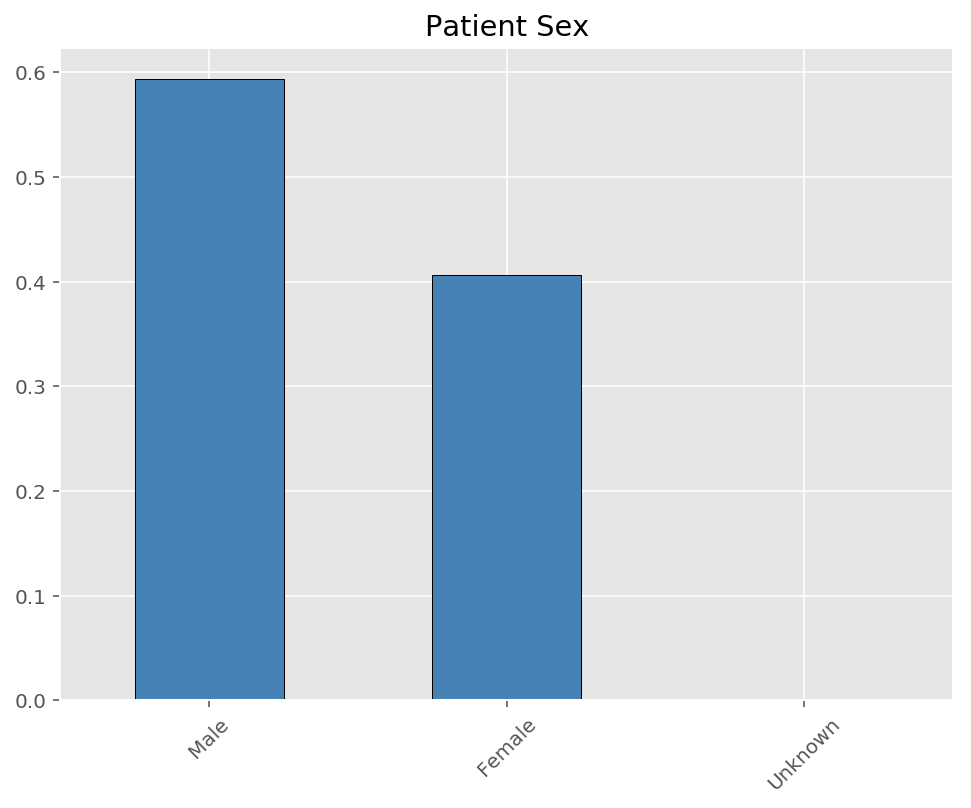

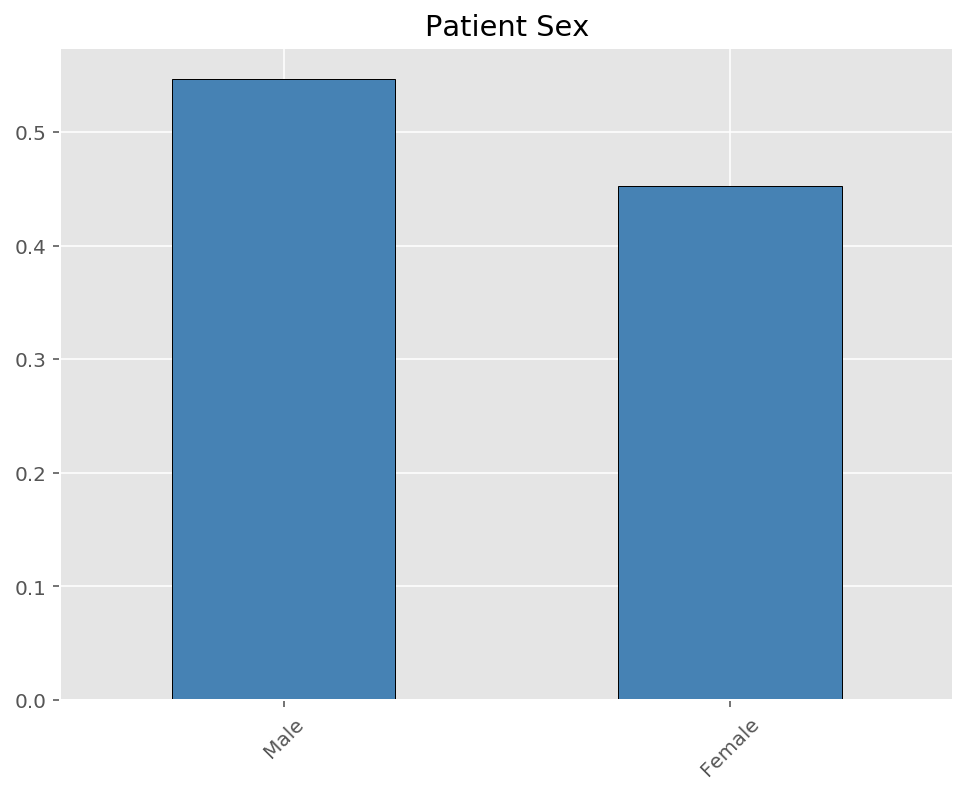

In [19]:
eda.patient_sex_bar_graph([train_df, valid_df])

# _Observations: Patient Sex_

From the value counts and bar graphs above we can see that nearly 60% of the patients are male in the training set, which equals over 132k observations. 

This is in contrast to the validation set, which has a roughly 55/45 split with ~55% of the patients being male and ~45% being female. 

Next let's take a look at the distribution of the patients ages. 

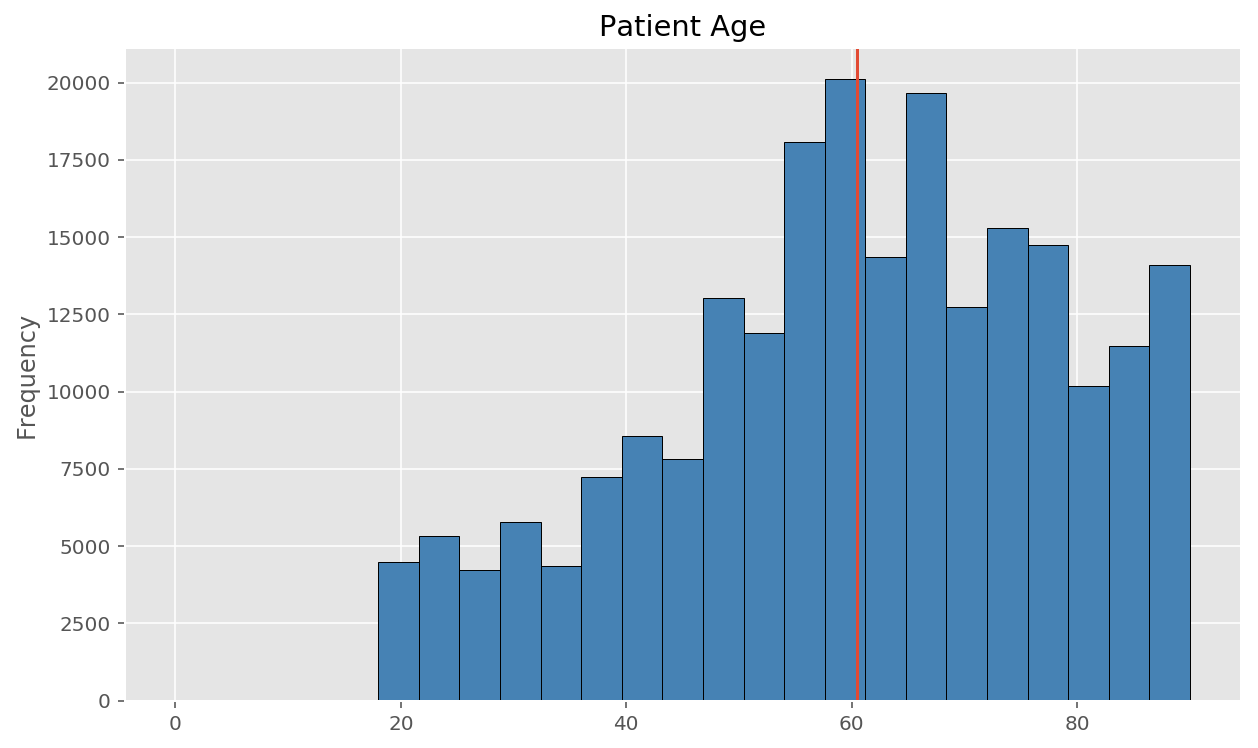

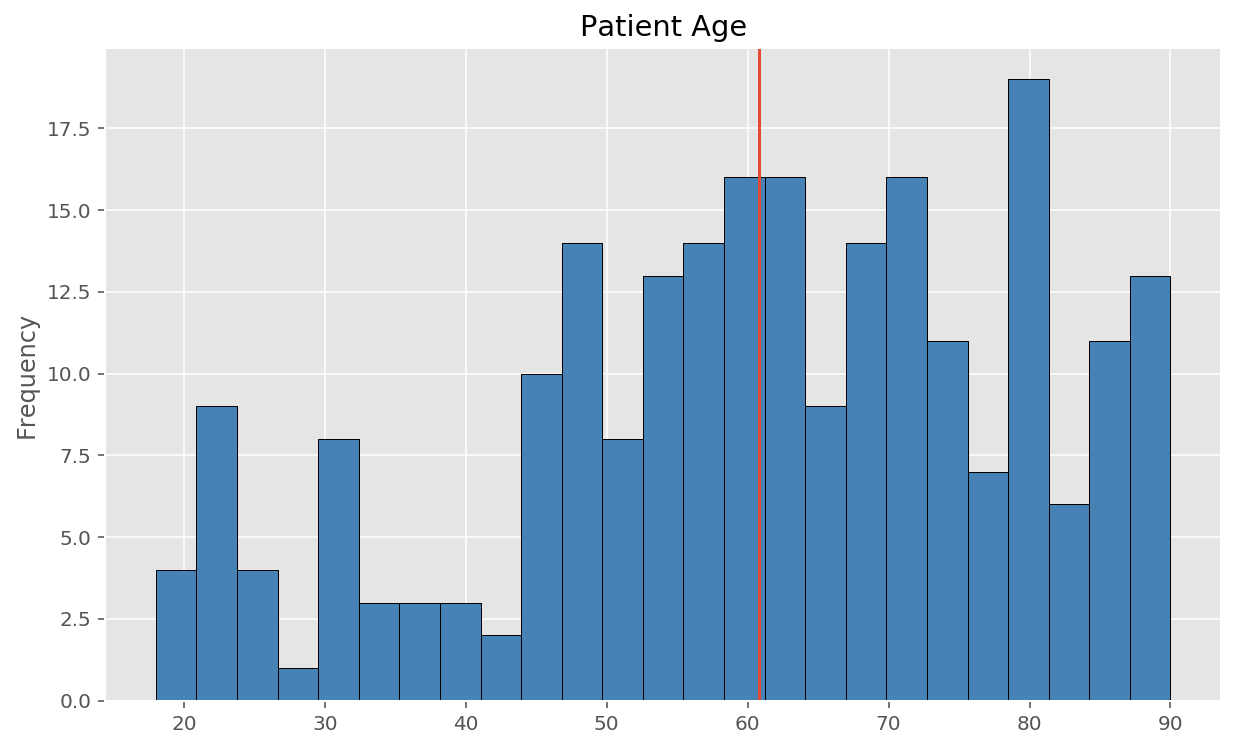

In [20]:
eda.patient_age_hist([train_df, valid_df])

# _Observations: Patient Age_

The first aspect that sticks out about the histograms above (top: `train_df`, bottom: `valid_df`) is that around age 50, there is a significant uptick in the number of cases as evidenced by the higher bar heights. The bins climb steadily until the age 60 bin (which contains a range of ages around 60), which serves as the peak in the training set (top histogram) and represents the second highest peak in the validation set (bottom histogram). 

The red line that vertically cuts through both the histograms represents the mean age of that particular cohort. They both look to be around the same at slightly over 60 years of age. When we take a look at the `train_df` (i.e., top) histogram, we can see that the values on the x-axis start at 0. Why is this? An initial hypothesis could be that there are observations that may have an age of `0`, which we'll have to explore further. 

When we compare the two histograms, we can see some slight differences in their distribution. While both appear to peak at approximately the same point (around age 60) the distribution to either side is different. For ages greater than 60, the `train_df` has a downward trend with a spike in the number of individuals whose ages are in the late-80s. For the `valid_df` histogram, there are spikes around every decade, i.e., age 70, 80 and 90. 

Now let's take a look at the lower end, the observations whose age is less than 60. From the ages of 20 to 40, the number of observations in `train_df` remains pretty consistent with a slight uptick from approximately ages 40 to 50. This is slightly different however from the `valid_df` which again shows an uptick around the decade marks of age 20 and 30, then a sudden spike around the late-40s. 

There is one thing that we have to keep in mind though when comparing the training and validation set: the training set is ~223,000 observations while the validation set is only 234, which is approximately ~0.1% of the training data. Overall, the two histograms are not the same but are relatively close in shape, which is pretty spectacular, considering the gap in the number of observations between the two data sets. 

Before we analyze pathologies, let's take a deeper dive into the training set to determine what is going on with the observations that are less than age 20. 

# CONTINUE HERE JULY 15

In [21]:
train_df[train_df['Age'] <= 20].shape

(3223, 19)

## _Analyze Pathologies_

In [22]:
eda.analyze_pathologies(train_df)

Atelectasis
------------------------------
 0    0.699594
-1    0.151016
 1    0.149391
Name: Atelectasis, dtype: float64

Cardiomegaly
------------------------------
 0    0.842951
 1    0.120852
-1    0.036197
Name: Cardiomegaly, dtype: float64

Consolidation
------------------------------
 0    0.809658
-1    0.124173
 1    0.066169
Name: Consolidation, dtype: float64

Edema
------------------------------
 0    0.708031
 1    0.233853
-1    0.058116
Name: Edema, dtype: float64

Enlarged Cardiomediastinum
------------------------------
 0    0.896152
-1    0.055516
 1    0.048332
Name: Enlarged Cardiomediastinum, dtype: float64

Fracture
------------------------------
 0    0.956663
 1    0.040463
-1    0.002874
Name: Fracture, dtype: float64

Lung Lesion
------------------------------
 0    0.952223
 1    0.041116
-1    0.006660
Name: Lung Lesion, dtype: float64

Lung Opacity
------------------------------
 0    0.502363
 1    0.472580
-1    0.025057
Name: Lung Opacity, dtype: float

# _Analyze Uncertain, Positive, and Negative Labels Amongst Pathologies_

In [23]:
pathology_list = sorted(list(train_df.columns[5:]))
pathology_list

['Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Enlarged Cardiomediastinum',
 'Fracture',
 'Lung Lesion',
 'Lung Opacity',
 'No Finding',
 'Pleural Effusion',
 'Pleural Other',
 'Pneumonia',
 'Pneumothorax',
 'Support Devices']

In [24]:
# create a dictionary that contains the number of uncertain labels for each pathology
uncertainty_dict = eda.uncertainty_dict(pathology_list, train_df)

Atelectasis: 33739 or 15.1% of observations in that column.
Cardiomegaly: 8087 or 3.62% of observations in that column.
Consolidation: 27742 or 12.42% of observations in that column.
Edema: 12984 or 5.81% of observations in that column.
Enlarged Cardiomediastinum: 12403 or 5.55% of observations in that column.
Fracture: 642 or 0.29% of observations in that column.
Lung Lesion: 1488 or 0.67% of observations in that column.
Lung Opacity: 5598 or 2.51% of observations in that column.
No Finding: 0 or 0.0% of observations in that column.
Pleural Effusion: 11628 or 5.2% of observations in that column.
Pleural Other: 2653 or 1.19% of observations in that column.
Pneumonia: 18770 or 8.4% of observations in that column.
Pneumothorax: 3145 or 1.41% of observations in that column.
Support Devices: 1079 or 0.48% of observations in that column.


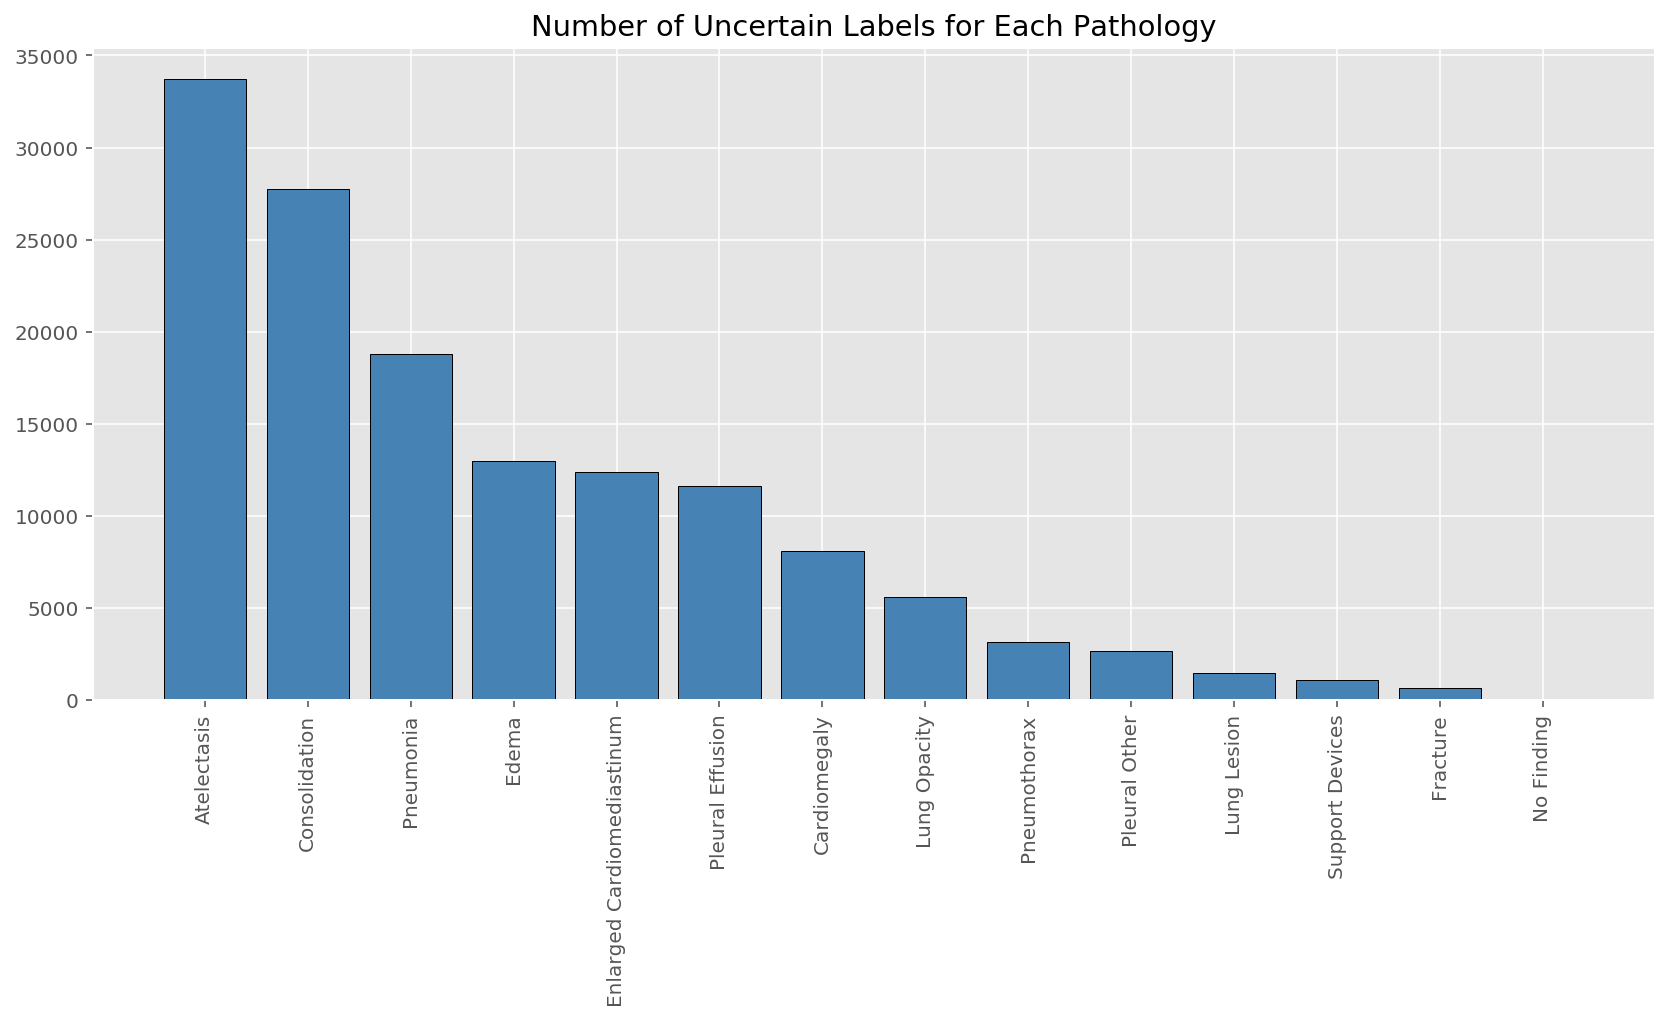

In [25]:
# visualization of uncertain labels for each pathology
eda.plt_dict(uncertainty_dict, 'Uncertain')

In [26]:
# create dictionary which stores negative observations for each pathology
negative_dict = eda.negative_dict(pathology_list, train_df);

Atelectasis: 156299 or 69.96% of observations in that column.
Cardiomegaly: 188327 or 84.3% of observations in that column.
Consolidation: 180889 or 80.97% of observations in that column.
Edema: 158184 or 70.8% of observations in that column.
Enlarged Cardiomediastinum: 200213 or 89.62% of observations in that column.
Fracture: 213732 or 95.67% of observations in that column.
Lung Lesion: 212740 or 95.22% of observations in that column.
Lung Opacity: 112235 or 50.24% of observations in that column.
No Finding: 201033 or 89.98% of observations in that column.
Pleural Effusion: 125599 or 56.22% of observations in that column.
Pleural Other: 217238 or 97.24% of observations in that column.
Pneumonia: 198605 or 88.9% of observations in that column.
Pneumothorax: 200821 or 89.89% of observations in that column.
Support Devices: 106334 or 47.6% of observations in that column.


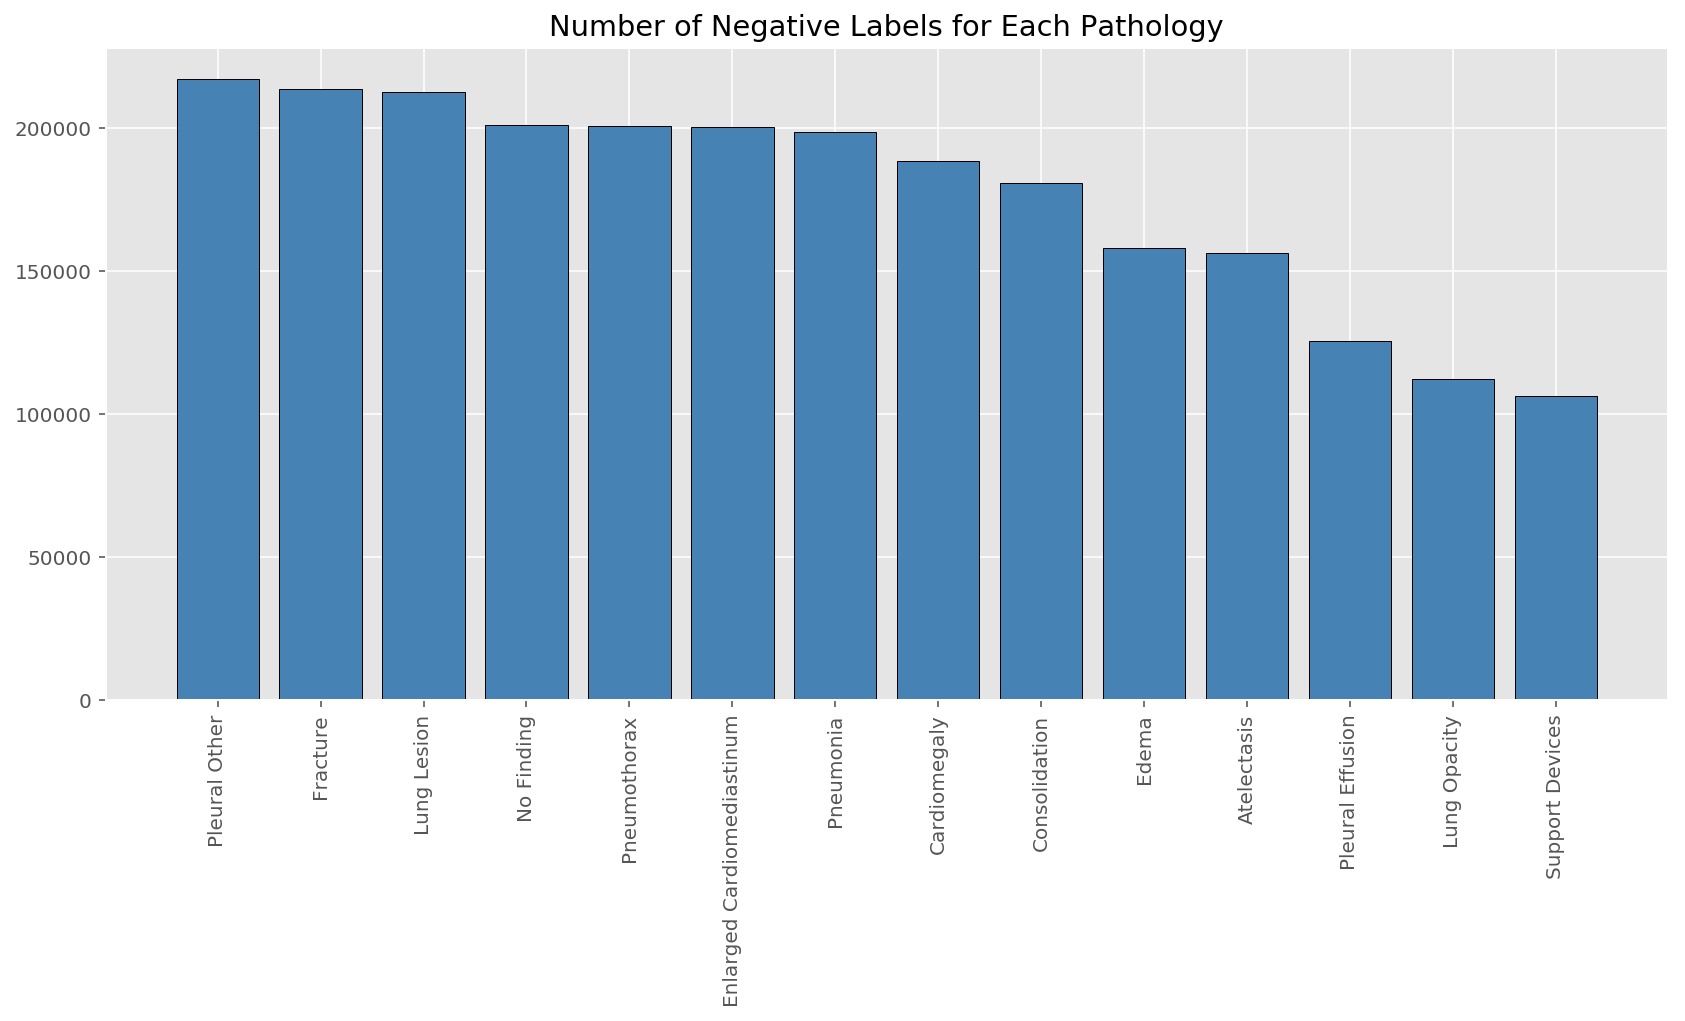

In [27]:
# visualization of negative labels for each pathology
eda.plt_dict(negative_dict, 'Negative')

In [28]:
# create dictionary storing positive observations for each pathology
positive_dict = eda.positive_dict(pathology_list, train_df);

Atelectasis: 33376 or 14.94% of observations in that column.
Cardiomegaly: 27000 or 12.09% of observations in that column.
Consolidation: 14783 or 6.62% of observations in that column.
Edema: 52246 or 23.39% of observations in that column.
Enlarged Cardiomediastinum: 10798 or 4.83% of observations in that column.
Fracture: 9040 or 4.05% of observations in that column.
Lung Lesion: 9186 or 4.11% of observations in that column.
Lung Opacity: 105581 or 47.26% of observations in that column.
No Finding: 22381 or 10.02% of observations in that column.
Pleural Effusion: 86187 or 38.58% of observations in that column.
Pleural Other: 3523 or 1.58% of observations in that column.
Pneumonia: 6039 or 2.7% of observations in that column.
Pneumothorax: 19448 or 8.7% of observations in that column.
Support Devices: 116001 or 51.92% of observations in that column.


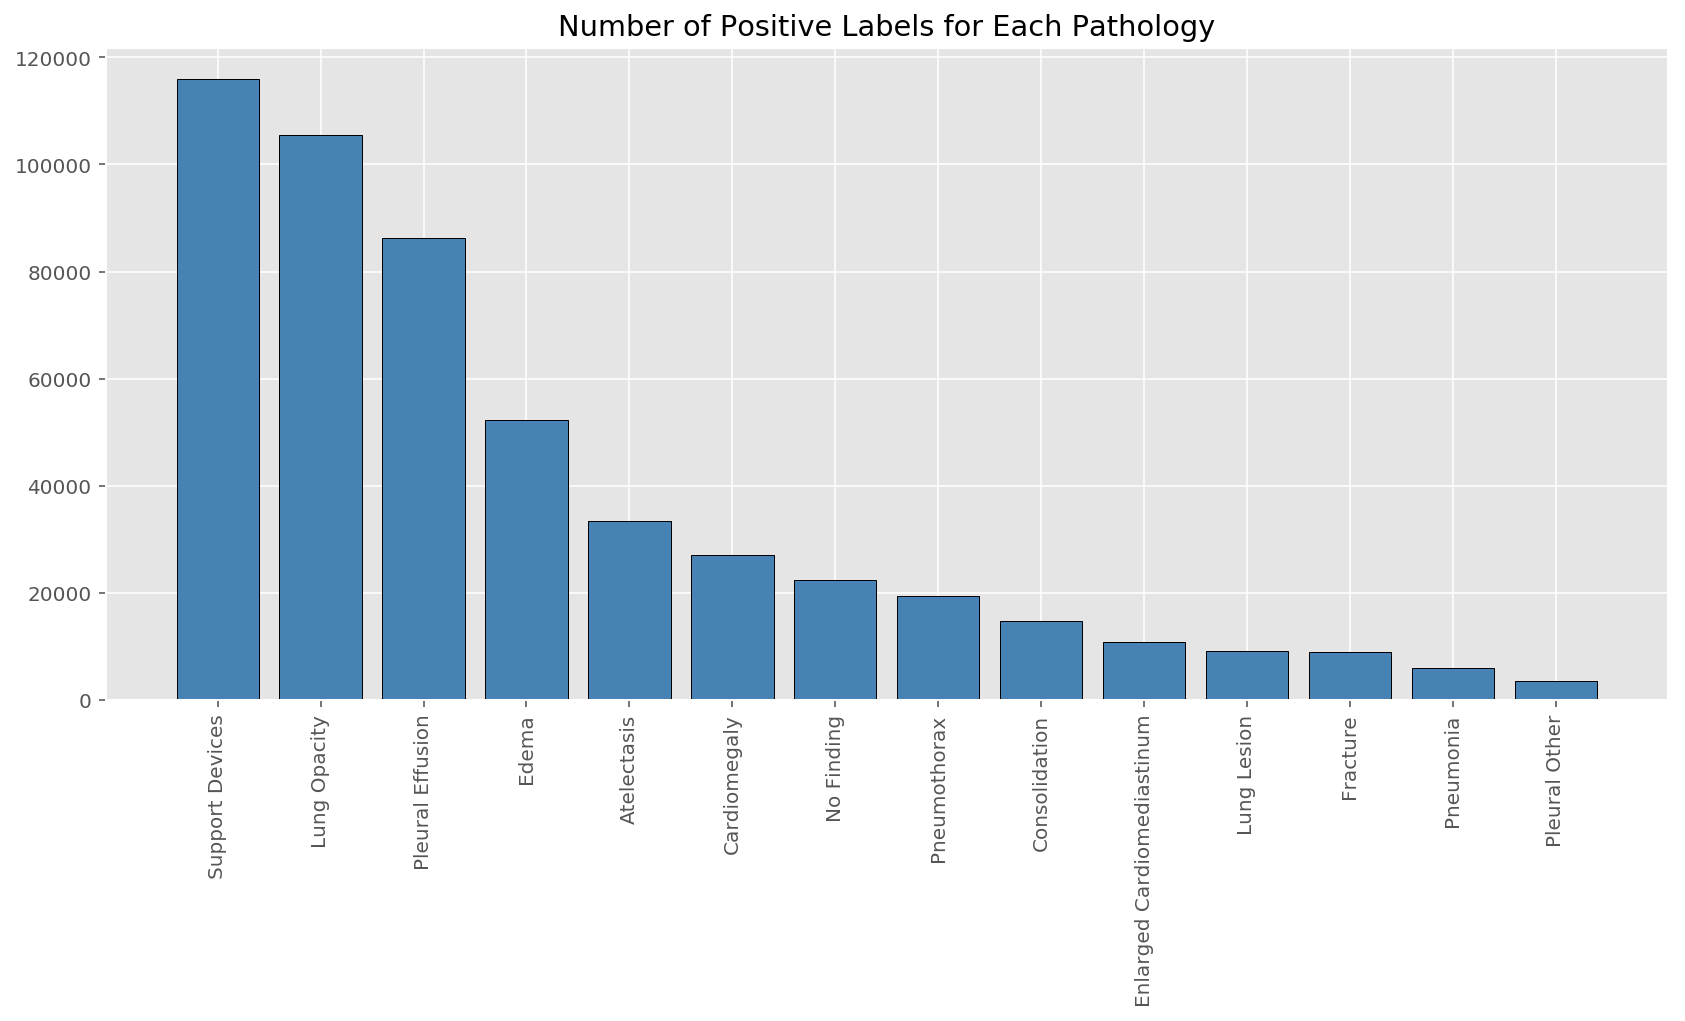

In [29]:
eda.plt_dict(positive_dict, 'Positive')

# _Deep Dive: Cardiomegaly_

For the deep learning portion of this project we'll be trying to classify whether or not an image is positive for `Cardiomegaly`.

If you're not a medical professional (which is most of us) you may be wondering...what is `Cardiomegaly`? According to [Dignity Health](https://www.dignityhealth.org/central-california/locations/stjosephs-stockton/services/heart-and-vascular-institute/heart-and-vascular-conditions/cardiomegaly), cardiomegaly is an enlarged heart and is not a condition itself but an abnormal physical finding resulting from a condition or disease. In essence, cardiomegaly develops as the result of another underlying condition, including (but not limited to):

- Congenital (i.e. condition you're born with)
- Damage from a heart attack
- Arrhythmia (i.e. abnormal heartbeat)
- High levels of stress
- High blood pressure
- Heart valve disease
- Cardiomyopathy (i.e. disease of the heart muscle)
- Pulmonary hypertension (i.e. high blood pressure in the artery connecting heart and lungs)
- Pericardial Effusion (i.e. fluid around your heart)

[(Source: Mayo Clinic)](https://www.mayoclinic.org/diseases-conditions/enlarged-heart/symptoms-causes/syc-20355436)

The major theme around most of these conditions is that they cause the heart to have to work harder than usual (i.e. pump harder) to move blood. As a result of having to work harder than it should, the heart grows in size to compensate. However, like a car that starts to break down after revving at high RPM's for too long, the heart begins to weaken.

This is where AI can potentially step in and help medical professionals better assess and diagnose patients that have cardiomegaly (in addition to all of the other pathologies listed in CheXpert). Before we get to far into the deep learning weeds, let's get a general overview of the demographics of the patients within the data set, particularly those with cardiomegaly. 

In [30]:
# create cardiomegaly data frame
cardiomegaly_df = train_df[train_df['Cardiomegaly'] == 1]

In [31]:
cardiomegaly_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27000 entries, 12 to 223412
Data columns (total 19 columns):
Path                          27000 non-null object
Sex                           27000 non-null category
Age                           27000 non-null int64
Frontal/Lateral               27000 non-null object
AP/PA                         23385 non-null object
No Finding                    27000 non-null int64
Enlarged Cardiomediastinum    27000 non-null int64
Cardiomegaly                  27000 non-null int64
Lung Opacity                  27000 non-null int64
Lung Lesion                   27000 non-null int64
Edema                         27000 non-null int64
Consolidation                 27000 non-null int64
Pneumonia                     27000 non-null int64
Atelectasis                   27000 non-null int64
Pneumothorax                  27000 non-null int64
Pleural Effusion              27000 non-null int64
Pleural Other                 27000 non-null int64
Fracture        

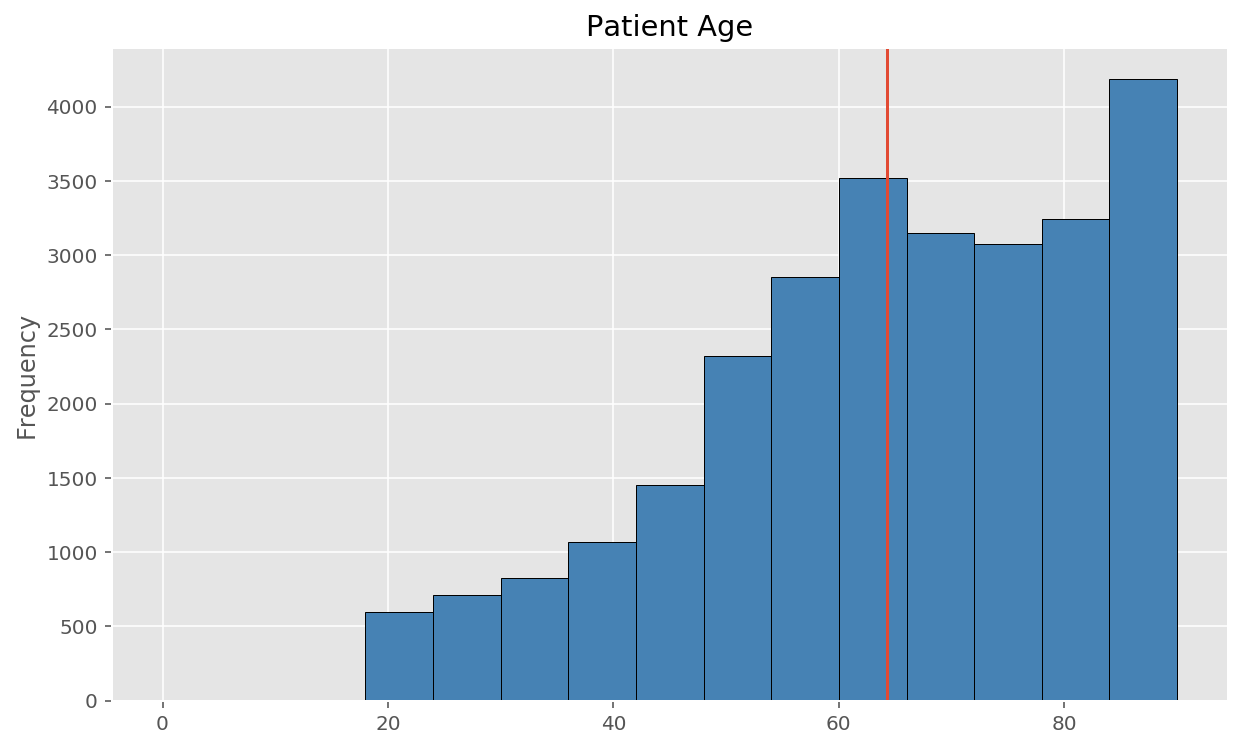

In [32]:
plt.figure()
cardiomegaly_df['Age'].plot(kind='hist', color='steelblue', edgecolor='black', bins=15, figsize=(10,6))
plt.axvline(x=np.mean(cardiomegaly_df['Age']))
plt.title('Patient Age');

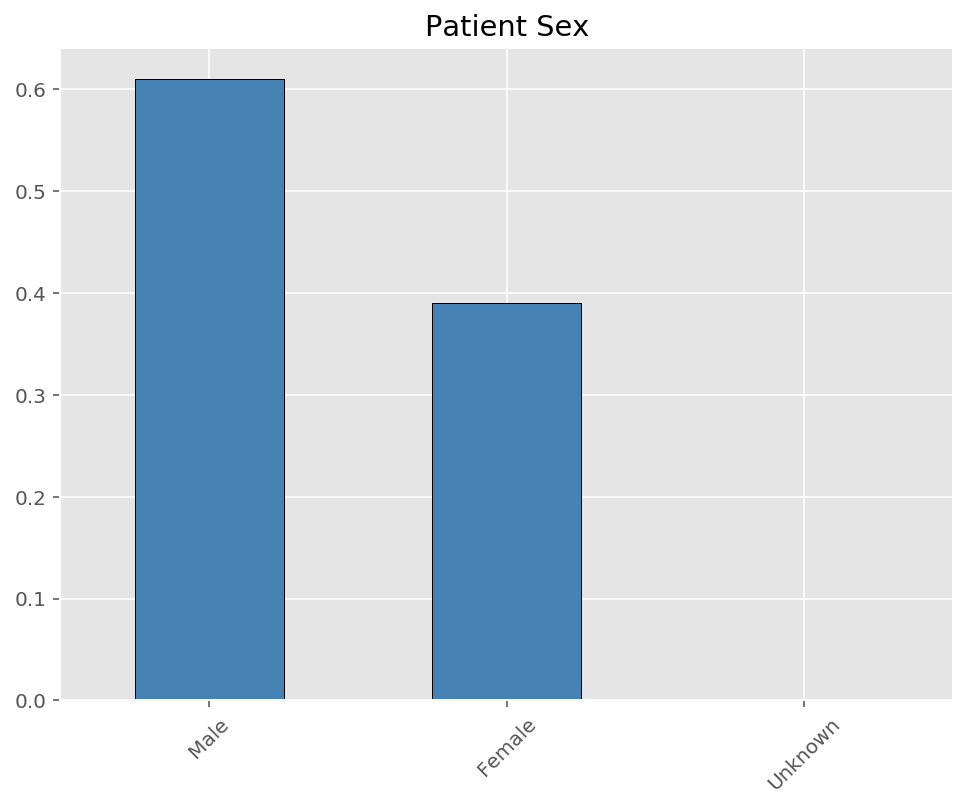

In [33]:
plt.figure(figsize=(8,6))
cardiomegaly_df['Sex'].value_counts(normalize=True).plot(kind='bar', color='steelblue', edgecolor='black')
plt.title('Patient Sex')
plt.xticks(rotation=45);

# _Observations_

From the initial graphs, the distribution in terms of patient age and sex don't seem to very to much from the overall data set. Let's take a look at the uncertain labels for cardiomegaly. In the case of CheXpert, an uncertain label was recorded if the labeler - which reviewed the medical notes associated with each observation - acknowledged that the documentation __may__ have indicated the presence of a respective pathology. It is important to note that this __does not__ mean that the pathology was present but still gives us some useful information. 

# _Exploring Uncertainty_

In [34]:
def uncertain_features(row):
    '''function that detects uncertain observations in each row and then outputs string of 
    uncertain labels
    '''
    feature_list = []
    for feature in pathologies:
        if row[feature] == -1:
            feature_list.append(feature)
            
    return '/'.join(feature_list)

In [35]:
pathologies = list(train_df.columns[5:])
pathologies

['No Finding',
 'Enlarged Cardiomediastinum',
 'Cardiomegaly',
 'Lung Opacity',
 'Lung Lesion',
 'Edema',
 'Consolidation',
 'Pneumonia',
 'Atelectasis',
 'Pneumothorax',
 'Pleural Effusion',
 'Pleural Other',
 'Fracture',
 'Support Devices']

In [36]:
%%time
train_df['uncertain_features'] = train_df.apply(uncertain_features, axis = 1)

CPU times: user 34.9 s, sys: 88.8 ms, total: 35 s
Wall time: 35.1 s


In [37]:
train_df['uncertain_features'] = train_df['uncertain_features'].replace('', 'None')

In [38]:
train_df.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,uncertain_features
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,Frontal,AP,1,0,0,0,0,0,0,0,0,0,0,0,0,1,None
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,Frontal,AP,0,0,-1,1,0,-1,-1,0,-1,0,-1,0,1,0,Cardiomegaly/Edema/Consolidation/Atelectasis/P...
2,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Frontal,AP,0,0,0,1,0,0,-1,0,0,0,0,0,1,0,Consolidation
3,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Lateral,NaN,0,0,0,1,0,0,-1,0,0,0,0,0,1,0,Consolidation
4,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,AP,0,0,0,0,0,1,0,0,0,0,0,0,0,0,None


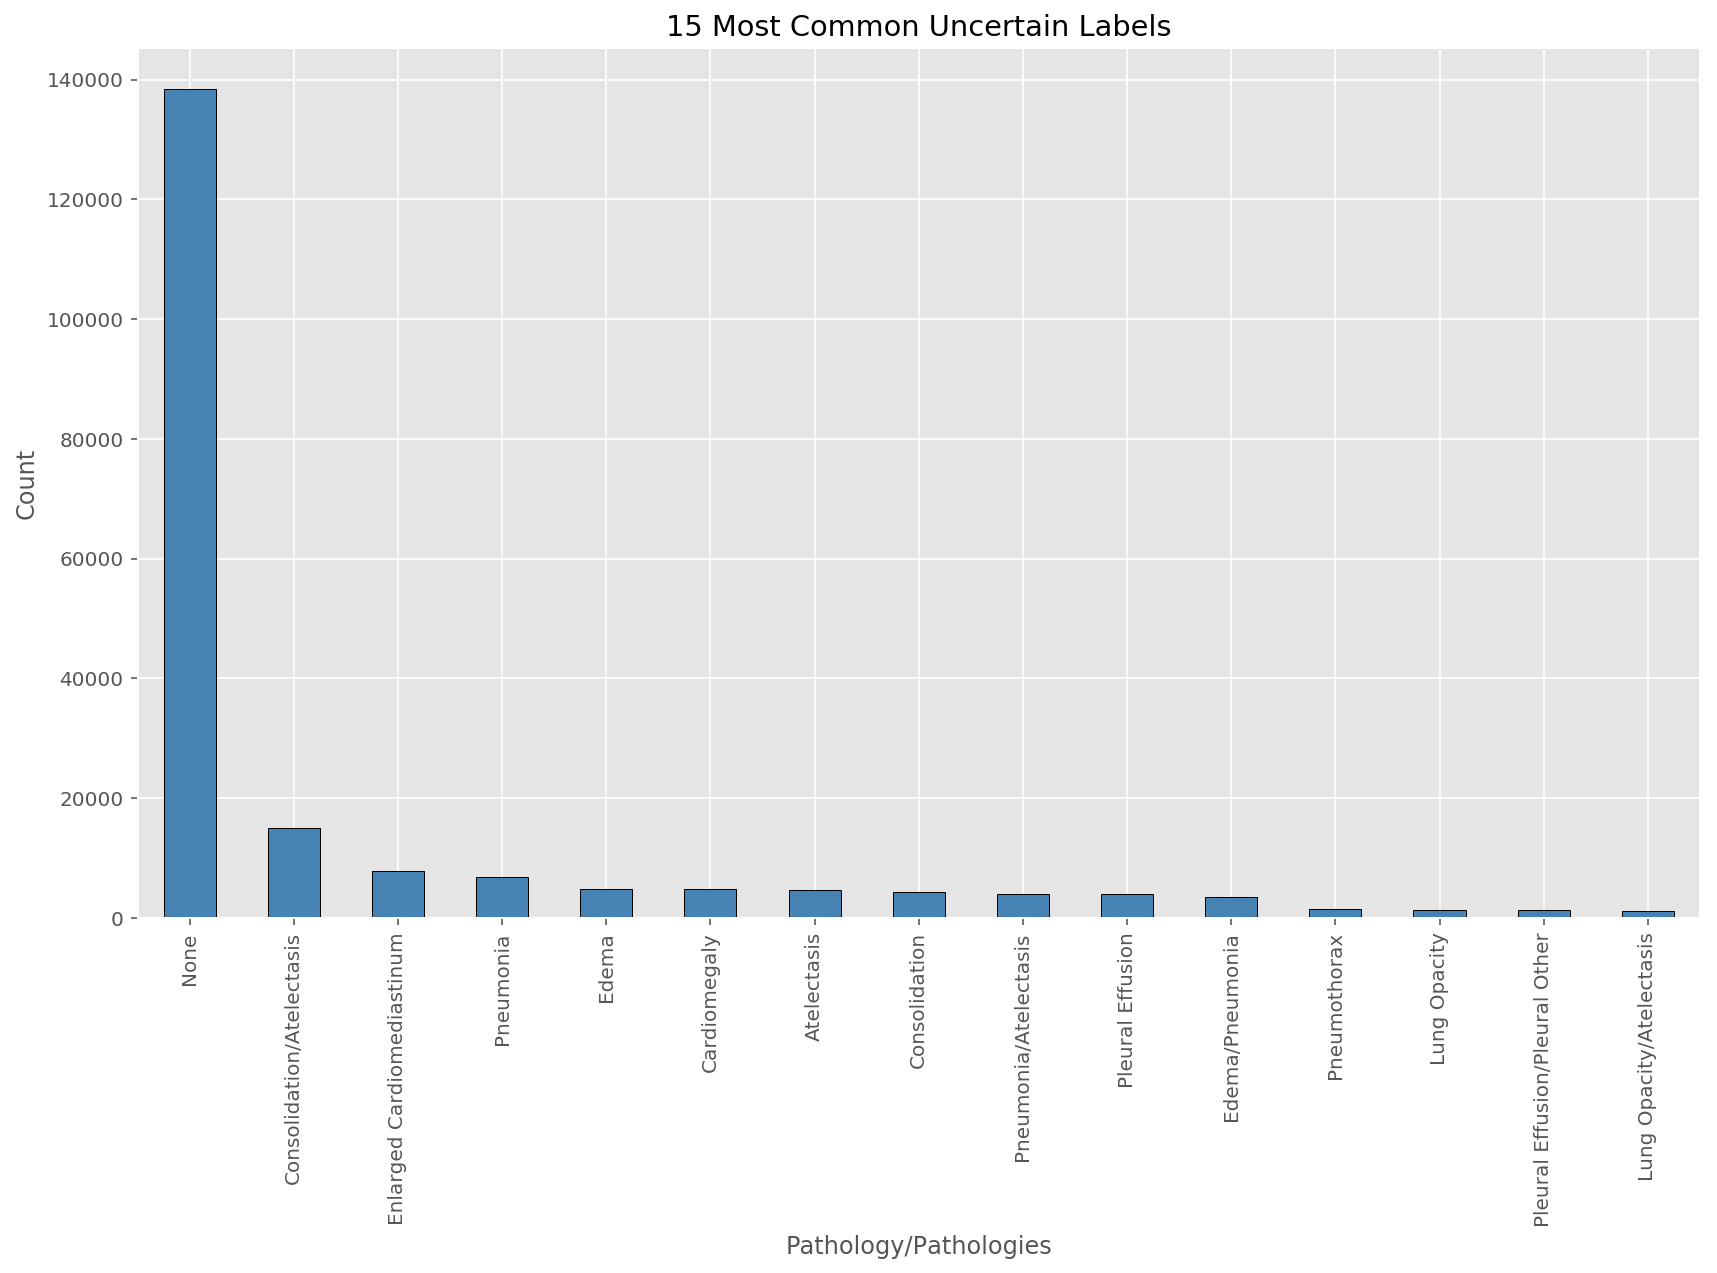

In [39]:
train_df['uncertain_features'].value_counts()[:15].plot(kind = 'bar', figsize=(14,8), color='steelblue',
                                                       edgecolor='black')
plt.xlabel('Pathology/Pathologies')
plt.ylabel('Count')
plt.title('15 Most Common Uncertain Labels');

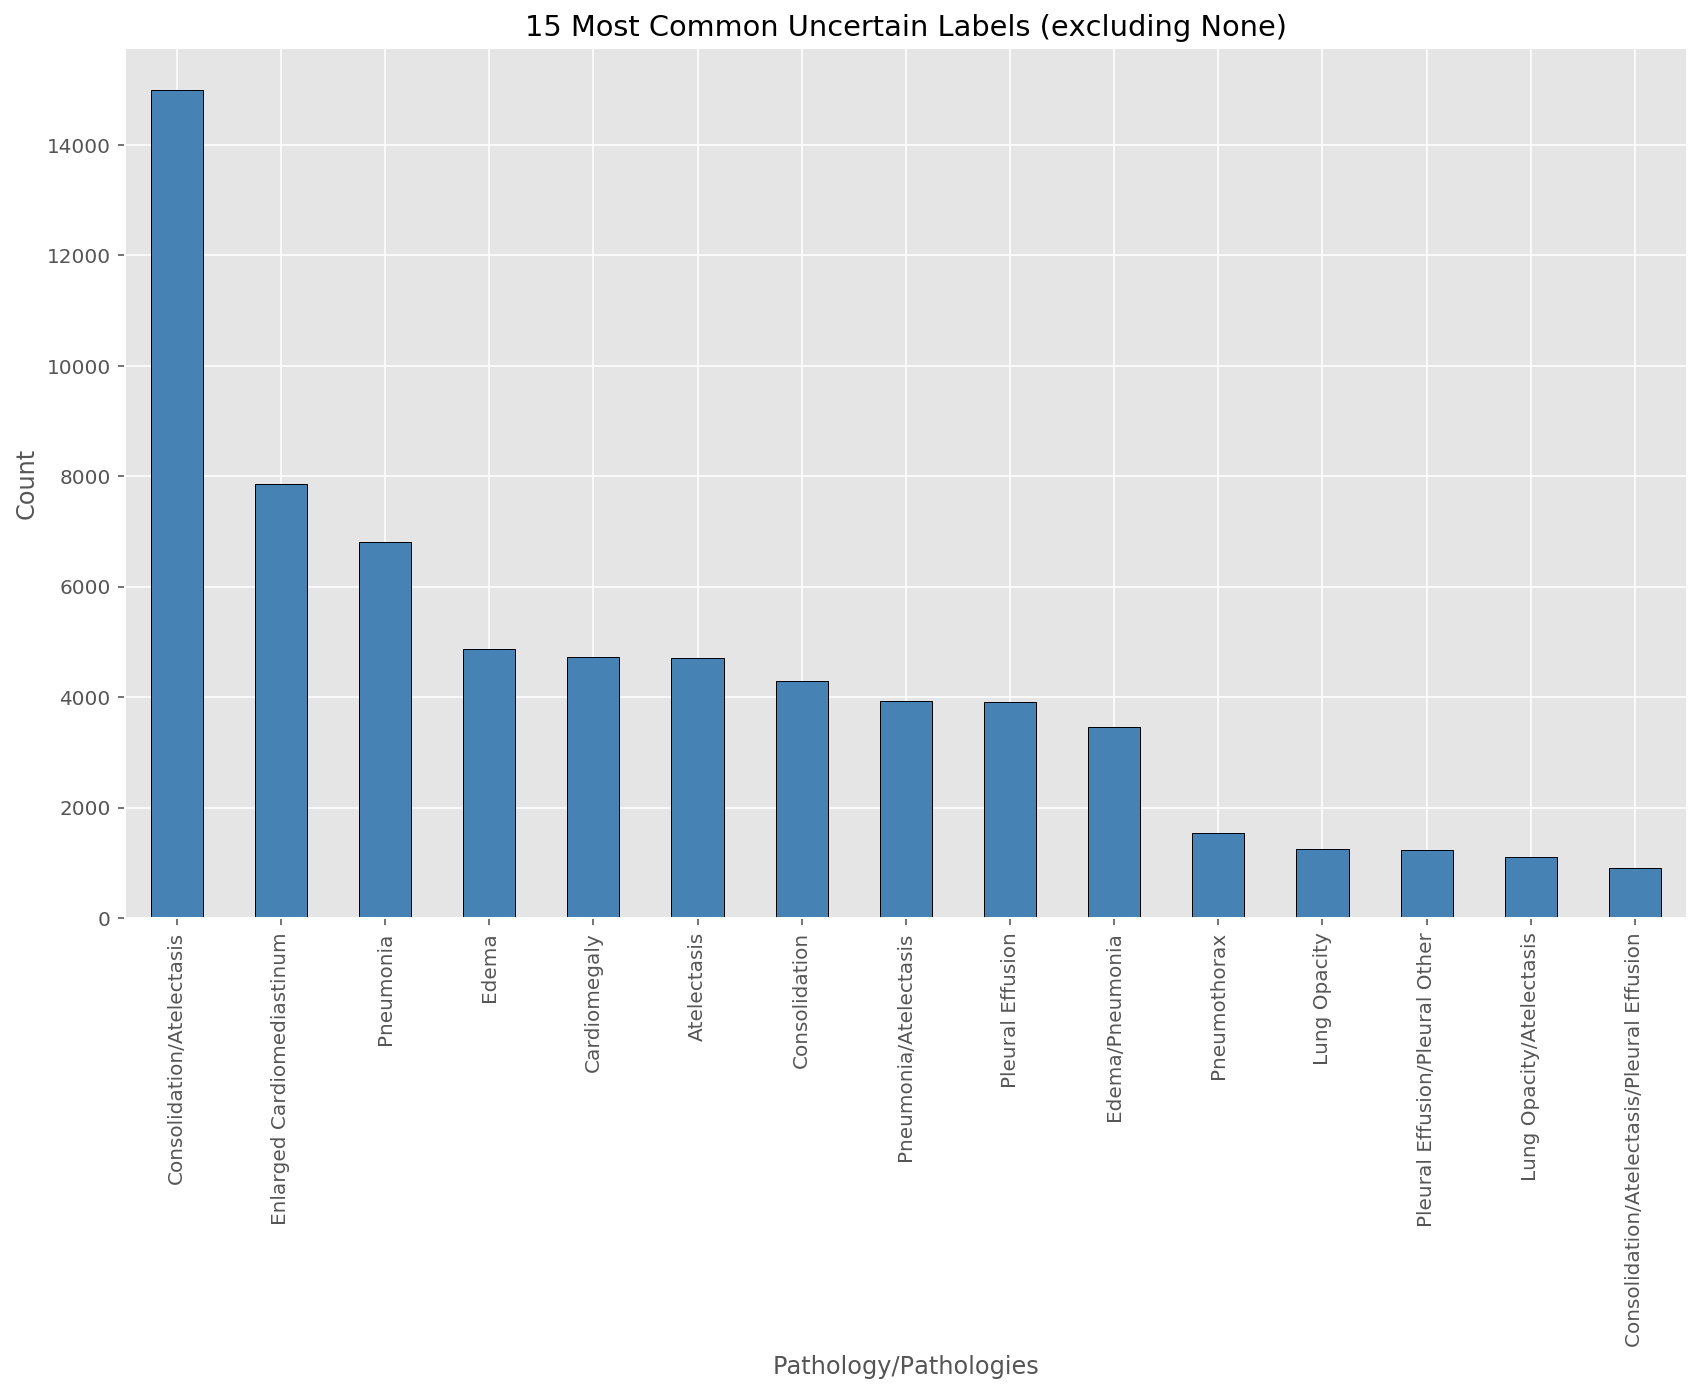

In [40]:
train_df['uncertain_features'].value_counts()[1:16].plot(kind = 'bar', figsize=(14,8), color='steelblue',
                                                       edgecolor='black')
plt.xlabel('Pathology/Pathologies')
plt.ylabel('Count')
plt.title('15 Most Common Uncertain Labels (excluding None)');

# _Can we use ML to label uncertain pathologies?_

For the last part of my EDA, I want to explore whether or not we can create an accurate machine learning model that we can then use to re-label the uncertain labels, specifically for cardiomegaly since this is our target pathology for the deep learning model. 

In [41]:
train_df.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,uncertain_features
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,Frontal,AP,1,0,0,0,0,0,0,0,0,0,0,0,0,1,None
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,Frontal,AP,0,0,-1,1,0,-1,-1,0,-1,0,-1,0,1,0,Cardiomegaly/Edema/Consolidation/Atelectasis/P...
2,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Frontal,AP,0,0,0,1,0,0,-1,0,0,0,0,0,1,0,Consolidation
3,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Lateral,NaN,0,0,0,1,0,0,-1,0,0,0,0,0,1,0,Consolidation
4,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,AP,0,0,0,0,0,1,0,0,0,0,0,0,0,0,None


So the first thing we need to do is drop the observations with uncertain labels. Remember, we are trying to see if we can predict these uncertain labels so having uncertainty in the data will only hinder our ability to potentially develop an accurate model. 

In [42]:
# make a copy of data set for machine learning 
ml_df = train_df.copy()

In [43]:
# drop all observations with any uncertainty
ml_df = ml_df[ml_df['uncertain_features'] == 'None'].reset_index(drop=True)
ml_df.shape

(138358, 20)

In [44]:
ml_df.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,uncertain_features
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,Frontal,AP,1,0,0,0,0,0,0,0,0,0,0,0,0,1,None
1,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,AP,0,0,0,0,0,1,0,0,0,0,0,0,0,0,None
2,CheXpert-v1.0-small/train/patient00004/study1/...,Female,20,Frontal,PA,1,0,0,0,0,0,0,0,0,0,0,0,0,0,None
3,CheXpert-v1.0-small/train/patient00004/study1/...,Female,20,Lateral,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,None
4,CheXpert-v1.0-small/train/patient00005/study1/...,Male,33,Frontal,PA,1,0,0,0,0,0,0,0,0,0,0,0,0,1,None


We won't need the `Path`, `AP/PA`, or `Frontal/Lateral` columns either so lets drop them as well. Additionally, since all the observations are `None` we can drop the `uncertain_features` column too.

In [45]:
ml_df = ml_df.drop(['Path', 'Frontal/Lateral', 'AP/PA', 'uncertain_features'], axis = 1)

In [46]:
ml_df.head()

,Sex,Age,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,Female,68,1,0,0,0,0,0,0,0,0,0,0,0,0,1
1,Male,41,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,Female,20,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Female,20,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Male,33,1,0,0,0,0,0,0,0,0,0,0,0,0,1


In [47]:
ml_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138358 entries, 0 to 138357
Data columns (total 16 columns):
Sex                           138358 non-null category
Age                           138358 non-null int64
No Finding                    138358 non-null int64
Enlarged Cardiomediastinum    138358 non-null int64
Cardiomegaly                  138358 non-null int64
Lung Opacity                  138358 non-null int64
Lung Lesion                   138358 non-null int64
Edema                         138358 non-null int64
Consolidation                 138358 non-null int64
Pneumonia                     138358 non-null int64
Atelectasis                   138358 non-null int64
Pneumothorax                  138358 non-null int64
Pleural Effusion              138358 non-null int64
Pleural Other                 138358 non-null int64
Fracture                      138358 non-null int64
Support Devices               138358 non-null int64
dtypes: category(1), int64(15)
memory usage: 16.0 MB


In [48]:
ml_df.isnull().sum()

Sex                           0
Age                           0
No Finding                    0
Enlarged Cardiomediastinum    0
Cardiomegaly                  0
Lung Opacity                  0
Lung Lesion                   0
Edema                         0
Consolidation                 0
Pneumonia                     0
Atelectasis                   0
Pneumothorax                  0
Pleural Effusion              0
Pleural Other                 0
Fracture                      0
Support Devices               0
dtype: int64

Next we need to encode all the pathologies. What does this mean? Well as is the values of `0` and `1`, which we know to represent negative and positive, respectively, for a particular pathology, are integer values. Now while they are technically numbers, they are more categorical in nature which is why we want to encode them.

In [49]:
ml_df[pathology_list] = ml_df[pathology_list].astype('category')

In [50]:
ml_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138358 entries, 0 to 138357
Data columns (total 16 columns):
Sex                           138358 non-null category
Age                           138358 non-null int64
No Finding                    138358 non-null category
Enlarged Cardiomediastinum    138358 non-null category
Cardiomegaly                  138358 non-null category
Lung Opacity                  138358 non-null category
Lung Lesion                   138358 non-null category
Edema                         138358 non-null category
Consolidation                 138358 non-null category
Pneumonia                     138358 non-null category
Atelectasis                   138358 non-null category
Pneumothorax                  138358 non-null category
Pleural Effusion              138358 non-null category
Pleural Other                 138358 non-null category
Fracture                      138358 non-null category
Support Devices               138358 non-null category
dtypes: cate

In [51]:
pd.get_dummies(ml_df['Sex'], prefix='Sex')

,Sex_Female,Sex_Male,Sex_Unknown
0,1,0,0
1,0,1,0
2,1,0,0
3,1,0,0
4,0,1,0
5,0,1,0
6,0,1,0
7,0,1,0
8,1,0,0
9,0,1,0


In [52]:
male_female = pd.get_dummies(ml_df['Sex'], prefix='sex')

In [53]:
data = pd.concat([male_female, ml_df], axis=1)

In [54]:
data.head()

,sex_Female,sex_Male,sex_Unknown,Sex,Age,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,1,0,0,Female,68,1,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,1,0,Male,41,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,1,0,0,Female,20,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,Female,20,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,1,0,Male,33,1,0,0,0,0,0,0,0,0,0,0,0,0,1


In [55]:
data.drop('Sex', axis = 1, inplace=True)

In [56]:
data.head()

,sex_Female,sex_Male,sex_Unknown,Age,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,1,0,0,68,1,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,1,0,41,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,1,0,0,20,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,20,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,1,0,33,1,0,0,0,0,0,0,0,0,0,0,0,0,1


Looks like we're all set to take a dive and see if we can't create a model to infer uncertain labels!

# _Machine Learning_

In [57]:
# create dataframe of features and the target variable Cardiomegaly
X = data.drop('Cardiomegaly', axis=1)
y = data['Cardiomegaly']

In [58]:
from sklearn.model_selection import train_test_split
# Split the data into 70% train and 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [59]:
from sklearn.ensemble import RandomForestClassifier

In [60]:
# we'll start with the default settings for our Random Forest Classifier
classifier = RandomForestClassifier(n_estimators=100, random_state=1, n_jobs=-1)

In [61]:
# fit random forest classifier to model
classifier.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [62]:
from sklearn.model_selection import cross_validate, cross_val_score
classifier_scores = cross_validate(classifier, X_train, y_train, cv=5,
                                   scoring=['roc_auc', 'precision', 'recall'],
                                   n_jobs=-1)

In [63]:
print(classifier_scores['test_roc_auc'].mean())
print(classifier_scores['test_precision'].mean())
print(classifier_scores['test_recall'].mean())

0.7431816346597913
0.36318086433978053
0.10919600543525879


- [`sklearn.metrics.roc_auc_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score)
- [The `scoring` parameter: defining model evaluation rules](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter)
- [`sklearn.model_selection.cross_validate`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate)

The above represents the mean Area Under the Receiver Operating Characteristic Curve prediction score. A value of ~`0.74` is decent but when we take a look at the precison and recall scores of `0.36` and `0.10` is not good. Let's explore the model a little further to see what features are the most important.

In [64]:
feature_imp = pd.Series(classifier.feature_importances_, index=X.columns).sort_values(ascending=False)

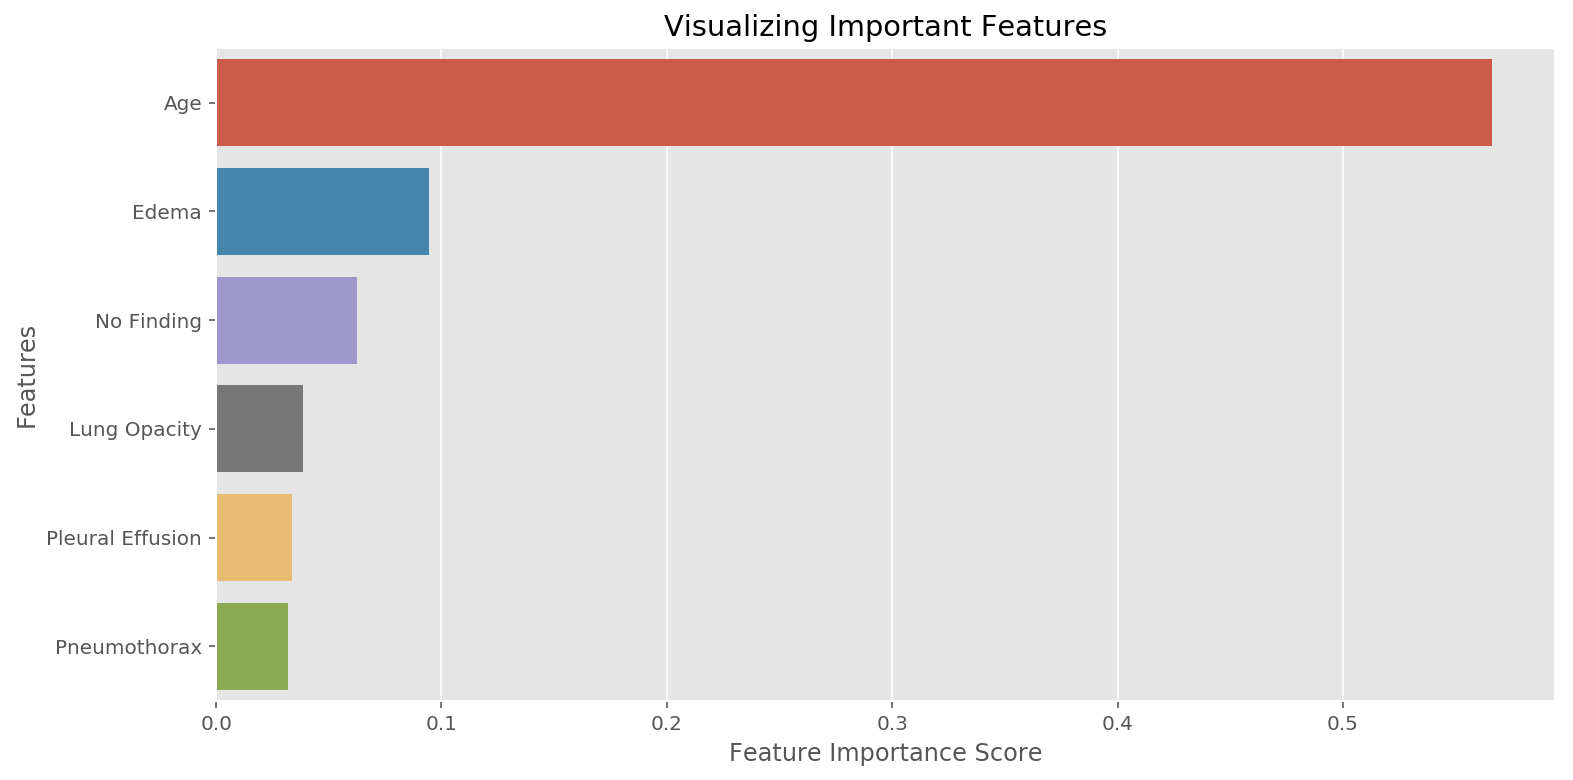

In [65]:
plt.figure(figsize=(12,6))
sns.barplot(x=feature_imp[:6], y=feature_imp.index[:6])
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features");

# CONTINUE HERE JULY 22